# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np

In [3]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [5]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [6]:
df.duplicated().value_counts()

False    23699
dtype: int64

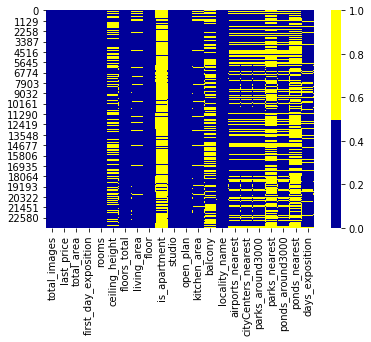

In [7]:

colours = ['#000099', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

### Вывод

В предоставленном датасете почти 24 тысячи записей, что можно считать неплохой выборкой. По большинству из параметров имеются пропуски, некоторые из них могут быть вполне объяснены типом параметра (отсутствие балкона, или отсутствие "галочки" в поле аппартаменты или свободная планировка) и проблем вызвать не должны. Другие же пропуски, такие как отсутствие информации о площади, этажности или высоте помещения вызовут больше проблем и с некоторой вероятностью могут быть не использованы. 
Явных дубликатов записей не обнаружено. 
По некоторым из параметров необходимо будет изменить тип значений.
Исходя из графика отсутствующих значений можно сделать вывод, что данные полученные автоматически во многих случаях отсутстуют по всем параметрам для отдельно записи, что может свидетельствовать о проблеме при их сборе или добавлении в датафрэйм.

## Предобработка данных

In [8]:
#пропуски
df['is_apartment'].value_counts()
df['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [9]:
values_to_fill = {'is_apartment': False, 'balcony': 0, 'parks_around3000': 0, 'ponds_around3000': 0}
df.fillna(value=values_to_fill,inplace=True)

In [10]:
df['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

Заполняем пропуски данных. 
В столбце is_apartment заменяем все отсутствующие значения на False, исходя из того, что апартаменты не частый вид недвижимости. Также стоит обратиться к, вероятно, разработчикам сайта или составителям анкеты, чтобы сделать заполнение этого значения обязательным (т.е. чтобы поле не оставалось пустым)
Пропуски по количеству балконов заполняем 0 исходя из того, что вероятно балконов нет, раз их количество не было указано. Если обратить внимание на то, как изменилось соотношение и сколько значений было не заполнено (половина) - вероятно проблема и в заполнении этих значений при сборе данных. Вероятно также в форме на сайте (если эту информацию клиент оставляет на сайте) это поле не обязательно к заполнению либо не имеет значения по умолчанию.

In [12]:
#кол-во комнтат == 0
df.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,NaN,24.0,15.50,2,False,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,181.0
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,NaN,14.0,17.00,1,False,False,True,NaN,0.0,деревня Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,45.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,False,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,NaN,26.0,24.30,19,False,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,NaN,10.0,NaN,7,False,True,False,NaN,0.0,посёлок Шушары,NaN,NaN,0.0,NaN,0.0,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,NaN,25.0,18.00,16,False,True,False,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,NaN,24.0,18.00,4,False,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,NaN,19.0,NaN,8,False,True,False,NaN,0.0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,NaN,9.0,18.00,8,False,False,True,NaN,2.0,Никольское,NaN,NaN,0.0,NaN,0.0,NaN,82.0


In [13]:
df['rooms'] = df['rooms'].where(df['rooms'] > 0, 1)

Заменяем значение 0 на 1 в квартирах, где не указано кол-во комнат. 0 комнат быть не может, предположим что их хотя бы одна

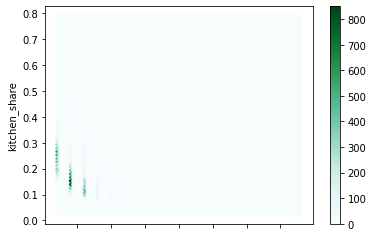

In [14]:
#площади
df['kitchen_share'] = df['kitchen_area']/df['total_area']
df.plot(y='kitchen_share', x='rooms', kind='hexbin', sharex=True)

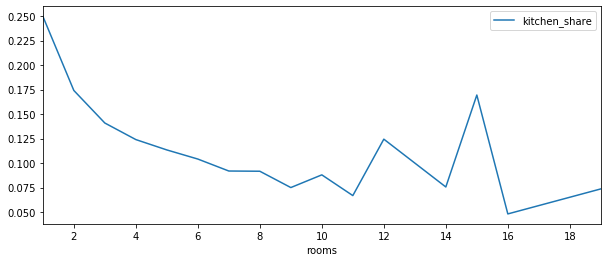

In [15]:
df.pivot_table(index='rooms', values='kitchen_share').plot(figsize=(10,4))

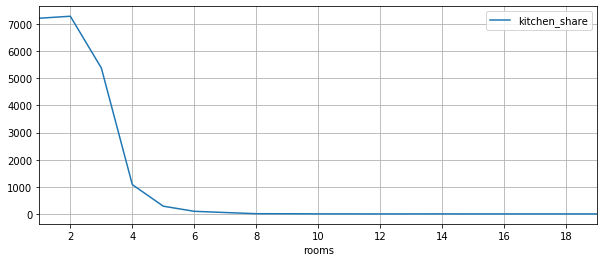

In [16]:
df.pivot_table(index='rooms', values='kitchen_share', aggfunc='count').plot(figsize=(10,4), xlim=(1,19), grid=True)

Исходя из графиков мы видим, что доля площади кухни связана с количеством комнат. а количество квартир с 2-мя и 5 и более комнатами сильно отличается, поэтому для заполнения недостающих значений будем использовать коэфициент для соотвутстующего кол-ва комнат, а не среднее/медианное значение для всех квартир.

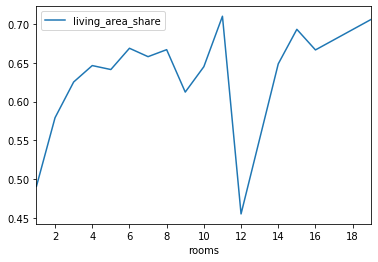

In [17]:
df['living_area_share'] = df['living_area']/df['total_area']
df.pivot_table(index='rooms', values='living_area_share').plot()

In [18]:
    df.query('rooms == 12')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,False,False,False,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,0.124444,0.455222


In [19]:
for room_quantity in df['rooms'].unique():
    df.loc[(df['rooms'] == room_quantity) & (df['living_area'].isna()), 'living_area'] = df.loc[(df['rooms'] == room_quantity) & (df['living_area'].isna()), 'total_area']*df.loc[df['rooms'] == room_quantity , 'living_area_share'].median()
    df.loc[(df['rooms'] == room_quantity) & (df['kitchen_area'].isna()), 'kitchen_area'] = df.loc[(df['rooms'] == room_quantity) & (df['kitchen_area'].isna()), 'total_area']*df.loc[df['rooms'] == room_quantity , 'kitchen_share'].median()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

Пропуски в жилой площади и площади кухни я заполнил произведением общей площади на медианную долю этих площадей для квартир с аналогичным количеством комнат.

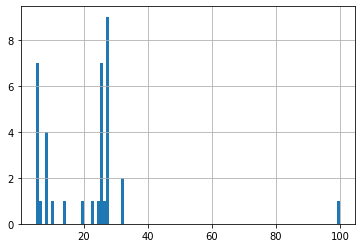

In [20]:
#попытаемся разобраться с высотой помещений
df['ceiling_height'].hist(bins=100, range=(5,100))

In [21]:
df.query('ceiling_height > 20')['ceiling_height'].value_counts()

27.0     8
25.0     7
32.0     2
22.6     1
100.0    1
27.5     1
26.0     1
24.0     1
Name: ceiling_height, dtype: int64

In [22]:
df.query('ceiling_height == 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,0.44,0.56


In [23]:
df.query('floors_total == 5.0 & living_area == 14.0 & locality_name == "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share
6387,8,4800000.0,35.00,2018-10-13T00:00:00,1,3.0,5.0,14.0,2,False,False,False,8.00000,0.0,Санкт-Петербург,20329.0,15131.0,3.0,158.0,1.0,525.0,NaN,0.228571,0.400000
6619,10,3230765.0,33.83,2018-10-10T00:00:00,1,NaN,5.0,14.0,1,False,False,False,8.38438,0.0,Санкт-Петербург,47303.0,25865.0,1.0,400.0,1.0,492.0,100.0,NaN,0.413834
17026,5,5200000.0,30.00,2017-04-23T00:00:00,1,NaN,5.0,14.0,4,False,False,False,7.00000,0.0,Санкт-Петербург,23974.0,3541.0,2.0,380.0,3.0,369.0,77.0,0.233333,0.466667
18927,6,6550000.0,35.00,2019-03-06T00:00:00,1,NaN,5.0,14.0,3,False,False,False,10.00000,0.0,Санкт-Петербург,20790.0,3155.0,3.0,420.0,1.0,952.0,30.0,0.285714,0.400000
21419,4,1870000.0,20.00,2018-03-06T00:00:00,1,2.5,5.0,14.0,1,False,False,False,2.00000,0.0,Санкт-Петербург,16652.0,15654.0,1.0,619.0,1.0,937.0,45.0,0.100000,0.700000
22869,0,15000000.0,25.00,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.00000,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,0.440000,0.560000
23384,3,2346000.0,34.00,2017-10-04T00:00:00,1,NaN,5.0,14.0,1,False,False,False,9.00000,0.0,Санкт-Петербург,13817.0,8928.0,1.0,406.0,1.0,1052.0,4.0,0.264706,0.411765


В таблице была одна запись с высотой помещения 100. Понимая, что это значение нереально для 5-этажного дома, я попытался найти значения для аналогичных квартир. Похожие по площади квартиры в домах с аналогичной высотностью не дали ответ, о типовой высоте потолка, но из них мы видим, что конкретная квартира сильно отличается по стоимости от аналогичных, не имеет фотографий. Вполне вероятно, информация не корректна и не подлежит использованию. Заменим это значение медианным.

In [24]:
pd.options.display.max_rows = 100 # не работает?
df['ceiling_height'].value_counts()

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
          ... 
27.50        1
5.00         1
3.59         1
4.80         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64

Сделав несколько срезов и посмотрев на заполненые данные по высоте потолков я выделил несколько групп:
 - указана высота до 5 метров - корректные данные
 - высота от 5 до 8 метров - все, кроме двух помещений отличаются высокой площадью, что может объяснять высоту помещения
 - от 8 до 20 метров - некорретные значения, необходимо заменить
 - от 20 до 40 метров - предполагаю, что сместилась точка в указании высоты (возможно пользователь указывал в дм, необходимо обратить внимание на этот момент при заполнении данных). Эти значения мы просто разделим на 10
 - от 40 метров и более - некорретные значения, необходимо заменить

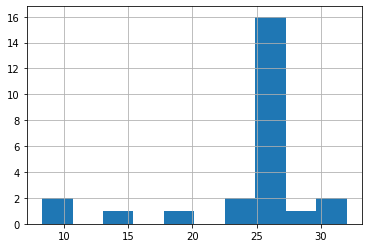

In [25]:
df.query('8 < ceiling_height < 100')['ceiling_height'].hist()

In [26]:
#df['ceiling_height'] = df['ceiling_height'].where((df['ceiling_height'] < 20) & (df['ceiling_height'] > 40), df['ceiling_height']/10)
df.loc[(df['ceiling_height'] > 20) & (df['ceiling_height'] < 40), 'ceiling_height'] = df.loc[(df['ceiling_height'] > 20)& (df['ceiling_height'] < 40), 'ceiling_height']/10

In [27]:
df.query('20 < ceiling_height < 40')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share


In [28]:
df.query('5 < ceiling_height < 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.2,8.0,159.500000,7,False,False,False,21.100000,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0,0.075276,0.569033
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.3,3.0,190.000000,3,False,False,False,63.000000,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN,0.203226,0.612903
1388,20,59800000.0,399.0,2015-01-21T00:00:00,5,5.6,6.0,260.085109,6,False,False,False,42.049180,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0,NaN,NaN
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.300000,2,False,False,False,7.300000,0.0,деревня Нурма,NaN,NaN,0.0,NaN,0.0,NaN,125.0,0.243333,0.510000
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.300000,14,False,False,False,8.300000,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0,0.184444,0.428889
7578,17,38000000.0,143.0,2017-11-02T00:00:00,3,5.5,5.0,83.000000,5,False,False,False,29.000000,1.0,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN,0.202797,0.580420
12628,14,3900000.0,50.0,2018-03-29T00:00:00,1,5.3,5.0,24.242424,5,False,False,False,12.391931,0.0,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0,NaN,NaN
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.400000,5,False,False,False,9.100000,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,0.161348,0.574468
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.000000,1,False,False,False,8.000000,0.0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0,0.119403,0.611940
17442,0,5350000.0,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.000000,2,False,False,False,8.698055,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0,NaN,0.537037


In [29]:
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] < 8, df['ceiling_height'].median())
df = df.loc[(df['ceiling_height'] >= df['ceiling_height'].quantile(.05))&(
    df['ceiling_height'] <= df['ceiling_height'].quantile(.95))]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22442 entries, 0 to 23698
Data columns (total 24 columns):
total_images            22442 non-null int64
last_price              22442 non-null float64
total_area              22442 non-null float64
first_day_exposition    22442 non-null object
rooms                   22442 non-null int64
ceiling_height          22442 non-null float64
floors_total            22356 non-null float64
living_area             22442 non-null float64
floor                   22442 non-null int64
is_apartment            22442 non-null bool
studio                  22442 non-null bool
open_plan               22442 non-null bool
kitchen_area            22442 non-null float64
balcony                 22442 non-null float64
locality_name           22397 non-null object
airports_nearest        16983 non-null float64
cityCenters_nearest     17002 non-null float64
parks_around3000        22442 non-null float64
parks_nearest           7230 non-null float64
ponds_around3000

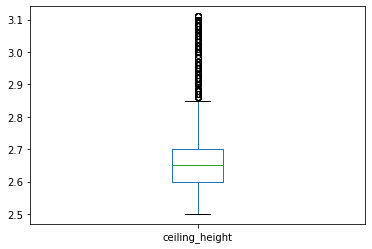

In [31]:
df['ceiling_height'].plot(kind='box')

In [32]:
df.query('floor > floors_total').count()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
kitchen_share           0
living_area_share       0
dtype: int64

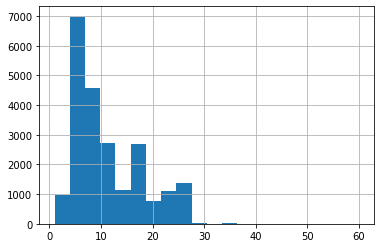

In [33]:
df['floors_total'].hist(bins=20)

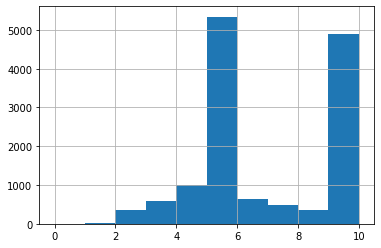

In [34]:
df['floors_total'].hist(bins=10, range=(0,10))

Убедились, что во всех заполненных случаях указанный этаж не выше этажности здания.

In [35]:
def floors_total_na(series):
    if pd.isna(series['floors_total']):
        if series['floor'] <= 5:
            return 5
        elif series['floor'] <=9:
            return 9
        else:
            return series['floor']
    else:
        return series['floors_total']
    
df['floors_total'] = df.apply(floors_total_na, axis=1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Пропущенные значения по этажности зданий заполнялись следующим образом:
 - если указанный этаж до 5-го включительно - присваивалось значение 5 этажей дому
 - если указанный этаж до 9-го включительно - присваивалось значение 9 этажей дому
 - если указан этаж выше 9 - этажности дома присваивалось значение равное указанному этажу

In [36]:
#названия городов
len(df.query('locality_name.isna()'))

45

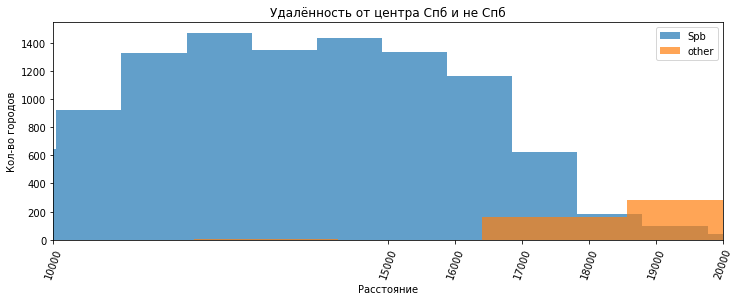

In [37]:
fig = plt.figure(figsize =(12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'], label='Spb', alpha=0.7, bins=30)
ax1.hist(df.query('locality_name != "Санкт-Петербург"')['cityCenters_nearest'], label='other', alpha=0.7, bins=30)
ax1.title.set_text('Удалённость от центра Спб и не Спб')
ax1.set_xlabel('Расстояние')
ax1.set_ylabel('Кол-во городов')
ax1.legend()
ax1.set_xticks([0,10000,15000,16000,17000,18000,19000,20000,30000])
plt.xticks(rotation=70)
plt.xlim(10000,20000)
plt.show()

In [38]:
df['locality_name'].value_counts()

Санкт-Петербург           14599
посёлок Мурино              522
посёлок Шушары              439
Всеволожск                  394
Пушкин                      349
                          ...  
поселок Калитино              1
поселок Гладкое               1
поселок Жилпосёлок            1
поселок Гончарово             1
деревня Нижние Осельки        1
Name: locality_name, Length: 362, dtype: int64

In [39]:
df.loc[(df['locality_name'].isna()) & (df['cityCenters_nearest'] < 17700), 'locality_name'] = 'Санкт-Петербург'
df.dropna(subset=['locality_name'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
len(df.query('locality_name.isna()'))

0

In [41]:
locality_names = df['locality_name'].unique()
locality_names

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'деревня Куттузи', 'Сестрорецк', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Отсутствующие значения я заполнил значением самой крупной группы, т.к. их кол-во невелико, а установить настоящий город расположения не предоставляется возможным.
При этом у нас 364 уникальных названия, среди которых есть тип населённого пункта с разным написанием. Необходимо убедиться, что дублей здесь нет.

In [42]:

print(collections.Counter(' '.join(locality_names).split()))
    

Counter({'поселок': 107, 'деревня': 106, 'посёлок': 92, 'городского': 39, 'типа': 39, 'городской': 13, 'село': 9, 'Бор': 8, 'станции': 8, 'товарищество': 5, 'Старая': 5, 'садовое': 4, 'Большая': 4, 'Мурино': 3, 'Новый': 3, 'Рощино': 3, 'Павлово': 3, 'имени': 3, 'Рябово': 3, 'коттеджный': 3, 'Янино-1': 2, 'Кудрово': 2, 'Красный': 2, 'Фёдоровское': 2, 'Лебяжье': 2, 'Кузьмоловский': 2, 'Новая': 2, 'Аннино': 2, 'Никольское': 2, 'Свет': 2, 'Романовка': 2, 'Бугры': 2, 'Победа': 2, 'Терволово': 2, 'Советский': 2, 'Петровское': 2, 'Токсово': 2, 'Вырица': 2, 'Тельмана': 2, 'Ижора': 2, 'Лесогорский': 2, 'Рахья': 2, 'Колпаны': 2, 'Ладога': 2, 'Зимитицы': 2, 'Свердлова': 2, 'Бегуницы': 2, 'Поляны': 2, 'Мга': 2, 'Малое': 2, 'Мичуринское': 2, 'Ильичёво': 2, 'Вещево': 2, 'Калитино': 2, 'Приладожский': 2, 'Щеглово': 2, 'Гаврилово': 2, 'Рабитицы': 2, 'Назия': 2, 'Малукса': 2, 'Гарболово': 2, 'Приветнинское': 2, 'Мельниково': 2, 'Усть-Луга': 2, 'Любань': 2, 'Стеклянный': 2, 'Форносово': 2, 'Сумино': 2, 

In [43]:
df['locality_name'] = df['locality_name'].str.replace('посёлок', 'поселок') 
df['locality_name'] = df['locality_name'].str.replace('коттеджный поселок', 'котеджный посёлок') 
df['locality_name'] = df['locality_name'].str.replace('городской поселок ', '') 
df['locality_name'] = df['locality_name'].str.replace('поселок станции', 'станция') 
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа ', '')
df['locality_name'] = df['locality_name'].str.replace('поселок при железнодорожной станции', 'станция') 
df['locality_name'] = df['locality_name'].str.replace('поселок ', '') 
df['locality_name'] = df['locality_name'].str.replace('деревня ', '') 
df['locality_name'] = df['locality_name'].str.replace('село ', '') 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [44]:
locality_names = df['locality_name'].unique()
locality_names

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'садовое товарищество Новая Ропша', 'Павловск',
       'Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'Куттузи', 'Сестрорецк', 'Аннино', 'Ефимовский', 'Плодовое',
       'Заклинье', 'Торковичи', 'Первомайское', 'Красное Село',
       'Понтонный', 'Сясьстрой', 'Старая', 'Лесколово', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Новый Свет', 'Оржицы', 'Кальтино',
       'Романовка', 'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', 'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин',
       'Победа', 'Нурма', 'Синявино', 'Тосно', 'Стрел

In [45]:
print(collections.Counter(' '.join(locality_names).split()))

Counter({'Бор': 6, 'станция': 6, 'товарищество': 5, 'садовое': 4, 'Старая': 4, 'Большая': 3, 'котеджный': 3, 'посёлок': 3, 'Новая': 2, 'Новый': 2, 'Романовка': 2, 'Рахья': 2, 'Колпаны': 2, 'Ладога': 2, 'имени': 2, 'Бегуницы': 2, 'Малое': 2, 'Приладожский': 2, 'Красная': 2, 'Горка': 2, 'Громово': 2, 'Лесное': 2, 'Санкт-Петербург': 1, 'Шушары': 1, 'Янино-1': 1, 'Парголово': 1, 'Мурино': 1, 'Ломоносов': 1, 'Сертолово': 1, 'Петергоф': 1, 'Пушкин': 1, 'Кудрово': 1, 'Коммунар': 1, 'Колпино': 1, 'Красный': 1, 'Гатчина': 1, 'Фёдоровское': 1, 'Выборг': 1, 'Кронштадт': 1, 'Кировск': 1, 'Новое': 1, 'Девяткино': 1, 'Металлострой': 1, 'Лебяжье': 1, 'Сиверский': 1, 'Молодцово': 1, 'Кузьмоловский': 1, 'Ропша': 1, 'Павловск': 1, 'Пикколово': 1, 'Всеволожск': 1, 'Волхов': 1, 'Кингисепп': 1, 'Приозерск': 1, 'Куттузи': 1, 'Сестрорецк': 1, 'Аннино': 1, 'Ефимовский': 1, 'Плодовое': 1, 'Заклинье': 1, 'Торковичи': 1, 'Первомайское': 1, 'Красное': 1, 'Село': 1, 'Понтонный': 1, 'Сясьстрой': 1, 'Лесколово': 1, 

Среди названий населённых пунктов были пересечения, когда по разному указывался тип населённого пункта. Для решения этой проблемы я убрал большинство типов населенных пунктов из их названий, для уникальных оставил либо сделал типовые значения.
Количество уникальных нас пунктов снизилось с 364 до 309

In [46]:
#срок активности объявлений
df.query('days_exposition == 1580')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share
18843,11,3500000.0,48.2,2014-12-15T00:00:00,2,2.5,5.0,27.4,2,False,False,False,7.7,3.0,Новое Девяткино,NaN,NaN,0.0,NaN,0.0,NaN,1580.0,0.159751,0.568465


In [47]:
#забегая вперёд вставим доп значения и попытаемся определить примерную дату выгрузки таблицы
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['weekday_exposition_start'] = df['first_day_exposition'].dt.weekday
df['month_exposition_start'] = df['first_day_exposition'].dt.month
df['year_exposition_start'] = df['first_day_exposition'].dt.year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [48]:
df.query('year_exposition_start == 2019')['days_exposition'].max()

110.0

In [49]:
df.query('year_exposition_start == 2019').sort_values(by='month_exposition_start', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start
19239,15,1290000.0,31.0,2019-05-01,1,2.90,2.0,17.4,2,False,False,False,8.0,0.0,Всеволожск,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.258065,0.561290,2,5,2019
16381,6,3800000.0,38.0,2019-05-01,1,2.50,16.0,18.0,2,False,False,False,8.0,2.0,Санкт-Петербург,12416.0,11638.0,1.0,460.0,1.0,598.0,NaN,0.210526,0.473684,2,5,2019
12343,12,2890000.0,48.8,2019-05-03,2,2.55,5.0,29.4,1,False,False,False,7.2,0.0,Рощино,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.147541,0.602459,4,5,2019
12380,9,3900000.0,35.6,2019-05-03,1,2.50,12.0,18.0,12,False,False,False,10.8,2.0,Санкт-Петербург,41522.0,12331.0,2.0,371.0,0.0,NaN,NaN,0.303371,0.505618,4,5,2019
5271,1,1100000.0,56.2,2019-05-02,2,2.55,5.0,32.6,1,False,False,False,8.4,2.0,Сумино,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.149466,0.580071,3,5,2019


In [50]:
df['sold'] = df['days_exposition'].notna()
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,3,3,2019,False
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,12,2018,True
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,3,8,2015,True
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,4,7,2015,True
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,1,6,2018,True


In [51]:
def sale_date_calc (series):
    if series['sold'] == True:
        return series['first_day_exposition'] + pd.Timedelta("{} day".format(series['days_exposition']))
    else:
        return 'none'

df['sale_day'] = df.apply(sale_date_calc, axis=1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,3,3,2019,False,none
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,12,2018,True,2019-02-23 00:00:00
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,3,8,2015,True,2017-02-28 00:00:00
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,4,7,2015,True,2016-09-20 00:00:00
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,1,6,2018,True,2018-10-18 00:00:00


In [52]:
df.loc[df['sale_day'] != 'none', 'sale_day'] = df.loc[df['sale_day'] != 'none', 'sale_day'].dt.date
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,3,3,2019,False,none
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,12,2018,True,2019-02-23
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,3,8,2015,True,2017-02-28
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,4,7,2015,True,2016-09-20
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,1,6,2018,True,2018-10-18


In [53]:
df.query('sale_day != "none"')['sale_day'].max()

datetime.date(2019, 5, 2)

Для заполнения пропусков по сроку активности объявлений я предположил, что их можно было бы заполнить отрезком времени от даты размещения до сегодняшнего дня. Но информация о дате выгрузки отсутствует, как и отсутствует о причинах отсутствующих значений (возможно это значит, что они ещё активны). Но если посмотреть на объявление с самый долгим сроком размещения - оно датируется 2014 годом и было снято через 4 года и 4 месяца, а последние объявления были размещены в мае 2019. Соответственно сравнивать с сегодняшней датой смысла нет. 
Для этого я нашёл дату последнего закрытия объявления и буду исходить из того, что это последняя дата операций в выгрузке. На основании этого значения я заполню недостающие значения по сроку активности не закрытых объявлений, а факт продажи будет зафиксирован в отдельном столбце. Таким образом я смогу отдельно оценить сроки продажи по успешным объявления и делать выводы по ещё не успешным, насколько затянулась продажа (на основании этой информации, к примеру, можно будет предлагать продавцу использовать доп инструменты для продвижения объявления)

In [54]:
df.loc[df['sold'] == False, 'sale_day'] = df.query('sale_day != "none"')['sale_day'].max()
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,3,3,2019,False,2019-05-02
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,12,2018,True,2019-02-23
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,3,8,2015,True,2017-02-28
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,4,7,2015,True,2016-09-20
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,1,6,2018,True,2018-10-18


In [55]:
df['sale_day'] = pd.to_datetime(df['sale_day'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22430 entries, 0 to 23698
Data columns (total 29 columns):
total_images                22430 non-null int64
last_price                  22430 non-null float64
total_area                  22430 non-null float64
first_day_exposition        22430 non-null datetime64[ns]
rooms                       22430 non-null int64
ceiling_height              22430 non-null float64
floors_total                22430 non-null float64
living_area                 22430 non-null float64
floor                       22430 non-null int64
is_apartment                22430 non-null bool
studio                      22430 non-null bool
open_plan                   22430 non-null bool
kitchen_area                22430 non-null float64
balcony                     22430 non-null float64
locality_name               22430 non-null object
airports_nearest            16979 non-null float64
cityCenters_nearest         16998 non-null float64
parks_around3000            22430

In [56]:
df.loc[df['sold'] == False, 'days_exposition'] = (df.loc[df['sold'] == False, 'sale_day'] - df.loc[df['sold'] == False, 'first_day_exposition']).dt.days
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,56.0,0.231481,0.472222,3,3,2019,False,2019-05-02
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,12,2018,True,2019-02-23
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,3,8,2015,True,2017-02-28
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,4,7,2015,True,2016-09-20
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,1,6,2018,True,2018-10-18


In [57]:
#типы данных
df['total_images'] = df['total_images'].astype('int8') #макс значение - 50
df['rooms'] = df['rooms'].astype('uint8')
df['floor'] = df['floor'].astype('uint8')
df['floors_total'] = df['floors_total'].astype('uint8')
#df['parks_around3000'] = df['parks_around3000'].astype('uint8')
#df['ponds_around3000'] = df['ponds_around3000'].astype('uint8')

df['days_exposition'] = df['days_exposition'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22430 entries, 0 to 23698
Data columns (total 29 columns):
total_images                22430 non-null int8
last_price                  22430 non-null float64
total_area                  22430 non-null float64
first_day_exposition        22430 non-null datetime64[ns]
rooms                       22430 non-null uint8
ceiling_height              22430 non-null float64
floors_total                22430 non-null uint8
living_area                 22430 non-null float64
floor                       22430 non-null uint8
is_apartment                22430 non-null bool
studio                      22430 non-null bool
open_plan                   22430 non-null bool
kitchen_area                22430 non-null float64
balcony                     22430 non-null float64
locality_name               22430 non-null object
airports_nearest            16979 non-null float64
cityCenters_nearest         16998 non-null float64
parks_around3000            22430 no

Заменяем типы данных там, где это очевидно возможно. Например, для даты размещения объявления или количественных показателей выраженных в целых числах и ограниченных логикой (к примеру этажей или комнат врядли будет отрицательное число либо более 255б мы видимо это в describe). Дату размещения переводим в формат даты
Часть данных уже была преобразована в другой тип в процессе заполнения пропусков.

In [58]:
#ещё дубликаты
key = ['locality_name', 'last_price', 'total_area', 'rooms', 'floor']

df.fillna(-999).groupby(key)['first_day_exposition'].count().sort_values(ascending=False).head(20)

locality_name    last_price  total_area  rooms  floor
Санкт-Петербург  7200000.0   70.0        3      2        4
                 4500000.0   45.0        2      2        4
                 2900000.0   31.0        1      1        4
                 3900000.0   45.0        2      3        4
                 3500000.0   31.0        1      3        4
                 3800000.0   46.0        2      2        4
                 3300000.0   32.0        1      9        4
                 3400000.0   32.5        1      7        3
                 5000000.0   60.0        3      7        3
                 5200000.0   48.0        2      4        3
                 4800000.0   57.0        3      1        3
                 3100000.0   31.0        1      5        3
                 3600000.0   38.0        1      6        3
                 2950000.0   30.0        1      5        3
                 4100000.0   45.0        2      1        3
                 4300000.0   42.0        1      14       3
  

После наведения порядка в датафрейме я проверил на наличие дубликатов по некоторым из признаков. Из таблицы выше видно, что есть несколько квартир в которых совпадают цена, расположение, общая площадь, количество комнат и этаж расположения. В случае с продажей первичного жилья это могли бы быть однотипные квартиры в одном доме, в случае продажи вторичного жилья - это может быть похоже на мошеничество - несколько объявлений для продажи одной и той же квартиры.

### Вывод

В предоставленном файле имеется большое количество пропущенных значений, нет явных дубликатов.
Были проработаны следующие поля:
    - 'is_apartment' - заполнили отсутствующие значения False, рекомендация - сделать в форме для заполнения это значение по умолчанию заполненным как "Нет"
    - 'balcony', 'rooms' - отсутствующие значения заполнил 0 исходя из того, что вероятно их не указали из-за отсутствия. Рекомендация: сделать в форме значение 0 по умолчанию
    - 'parks_around3000' и 'ponds_around3000' -  - отсутствующие значения заполнил 0 исходя из того, что вероятно их не указали из-за отсутствия. Рекомендация: сохранять 0 при отсутствии найденных системой парков и прудов
    - пропуски по площади жилых помещений и кухни были заполнены с помощью коэфициента такой площади от общей для квартир с аналогичным количеством комнат. Для расчётов сразу для каждой квартиры была посчитана доля таких площадей
    - высота помещений - часть значений были в диапазоне 24-32, исходя из предположения, что в данных при записи была смещена точка я уменьшил эти значения в 10 раз, все остальные заменил медианой
    - общее количество этажей в доме было заполнено исходя из предположения, что наиболее частые по высоте дома это 5 и 9 этаже. Все квартиры до 5 включительно этажа были причислены к 5-ти этажным домам, до 9 включительно - к девятиэтажным, в остальных случаях указанный этаж считался последним в здании
    - отсутствующие значения в названиях городов были заполнены самым широким значением, есть смысл сделать это поле в форме обязательным для заполнения. Также я взял все уникальных значения названий населённых пунктов, избавил их от уточняющих тип значений, которые создавали лишние дубли. По итогу уникальных значений стало на 20% меньше. Также рекомендую при заполнении формы на сайте предлагать пользователю уже готовые значения из списка.
    - срок активности объявлений - здесь я исходил из того, что если этот срок не указан - квартира ещё не продана. Но чтобы оценить, насколько долго она продаётся я добавил это значение как разницу между датой выставления на продажу и последней датой продажи в датафрейме. Также для сохранения инфорамции я добавил значения продана ли квартира или нет.

## Расчёты и добавление результатов в таблицу

In [59]:
# цена квадратного метра;

df['price_per_meter'] = (df['last_price']/df['total_area']).round(decimals=2)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day,price_per_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,56,0.231481,0.472222,3,3,2019,False,2019-05-02,120370.37
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,0.272277,0.460396,1,12,2018,True,2019-02-23,82920.79
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,0.148214,0.612500,3,8,2015,True,2017-02-28,92785.71
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,NaN,NaN,4,7,2015,True,2016-09-20,408176.10
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,0.410000,0.320000,1,6,2018,True,2018-10-18,100000.00


In [60]:
#этаж квартиры; варианты — первый, последний, другой

def floor_type(series):
    if series['floor'] == 1:
        return 'first'
    elif series['floor'] == series['floors_total']:
        return 'last'
    else:
        return 'other'
    
df['floor_type'] = df.apply(floor_type, axis=1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,sold,sale_day,price_per_meter,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000,8,False,False,False,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,56,0.231481,0.472222,3,3,2019,False,2019-05-02,120370.37,other
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600,1,False,False,False,11.000000,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,0.272277,0.460396,1,12,2018,True,2019-02-23,82920.79,first
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,0.148214,0.612500,3,8,2015,True,2017-02-28,92785.71,other
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,100.435,9,False,False,False,20.442857,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,NaN,NaN,4,7,2015,True,2016-09-20,408176.10,other
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000,13,False,False,False,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,0.410000,0.320000,1,6,2018,True,2018-10-18,100000.00,other


### Вывод



## Исследовательский анализ данных

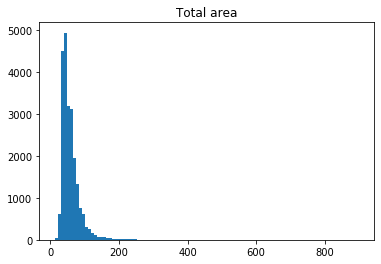

In [61]:
plt.hist(df['total_area'], bins=100)
plt.title('Total area')
plt.show()

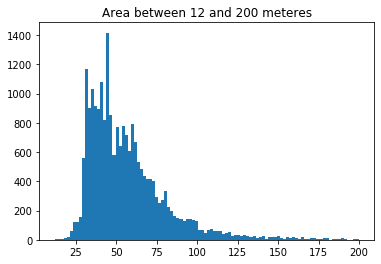

In [62]:
plt.hist(df['total_area'], bins=100, range=(12,200))
plt.title('Area between 12 and 200 meteres')
plt.show()

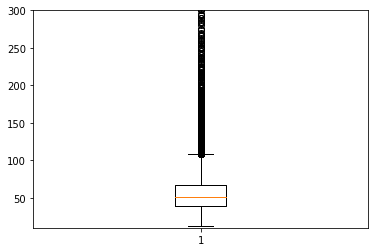

In [63]:
plt.boxplot(df['total_area'])
plt.ylim(10,300)

plt.show()

[array([39.6, 12. ]), array([ 67. , 108.1])]

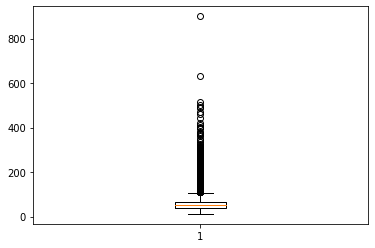

In [64]:
b = plt.boxplot(df['total_area'])
[item.get_ydata() for item in b['whiskers']]

In [65]:
len(df.query('total_area > 200'))

122

In [66]:
df_area_ok = df.query('total_area < 200')

In [67]:
df_area_ok['total_area'].value_counts()

45.00     415
42.00     380
31.00     345
44.00     342
60.00     332
         ... 
116.80      1
116.70      1
32.15       1
33.24       1
23.55       1
Name: total_area, Length: 1925, dtype: int64

Исходя из графиков можем сделать вывод, что для анализа мы можем взять данные от 12 до 115. Будут отброшены около 5% записей.
На графике видно выделяющееся значение среди всех в районе 45, посмотрев на value_counts можно понять, что это 45 и 42 метра. Моё предположение, что эти значения относятся к "хрущёвкам", которых в выборке получится немало. Также вероятно это повлияет на большое кол-во 2-х комнатных квартир с высотой 2,45 и 2,7 метра. С другой стороны - эти габариты вообще кажутся достаточно типичными для пост-советских стран.

In [68]:
df.query('total_area < 115')['total_area'].describe()

count    21566.000000
mean        53.634720
std         18.923006
min         12.000000
25%         39.000000
50%         50.000000
75%         64.300000
max        114.800000
Name: total_area, dtype: float64

In [69]:
df['total_area'].describe()

count    22430.000000
mean        57.813560
std         30.740268
min         12.000000
25%         39.600000
50%         50.700000
75%         67.000000
max        900.000000
Name: total_area, dtype: float64

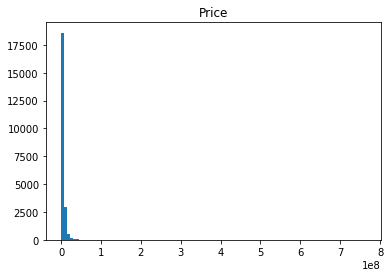

In [70]:
plt.hist(df['last_price'], bins=100)
plt.title('Price')
plt.show()

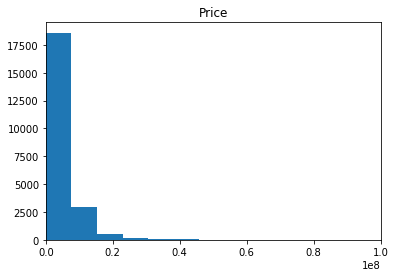

In [71]:
plt.hist(df['last_price'], bins=100)
plt.title('Price')
plt.xlim(0, 100000000)
plt.show()

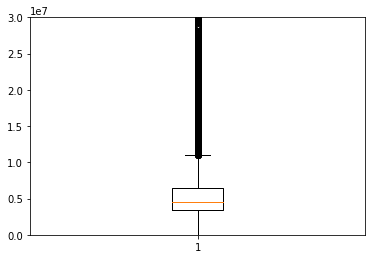

In [72]:
plt.boxplot(df['last_price'])
plt.ylim(0, 30000000)
plt.show()

[array([3390000.,   12190.]), array([ 6450000., 11000000.])]

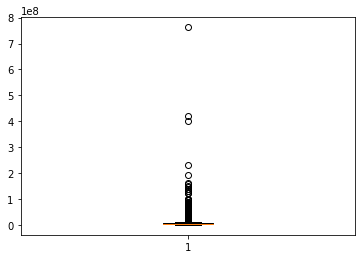

In [73]:
b = plt.boxplot(df['last_price'])
[item.get_ydata() for item in b['whiskers']]

In [74]:
len(df.query('last_price > 20000000'))

483

In [75]:
df['last_price'].describe()

count    2.243000e+04
mean     5.990621e+06
std      9.120090e+06
min      1.219000e+04
25%      3.390000e+06
50%      4.500000e+06
75%      6.450000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [76]:
df_price_ok = df.query('last_price < 20000000')

Около 18% значений по стоимости жилья находятся за пределами усов и мы можем отнести их к выборосам.

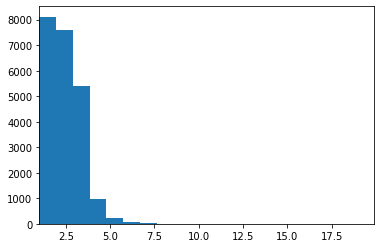

In [77]:
plt.hist(df['rooms'], bins=19)
plt.xlim(1,)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f71d22b8190>,
 'caps': [<matplotlib.lines.Line2D at 0x7f71d22b8bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f71d22b1510>],
 'medians': [<matplotlib.lines.Line2D at 0x7f71d22c0650>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f71d22c0b50>],
 'means': []}

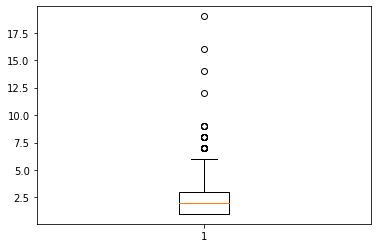

In [78]:
plt.boxplot(df['rooms'])


In [79]:
df.query('rooms > 9').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_share,living_area_share,weekday_exposition_start,month_exposition_start,year_exposition_start,price_per_meter
count,4.0,4.000000e+00,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.00000,4.00,4.000000,4.000000,4.000000,2.00000,4.0,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,6.5,1.273522e+08,447.500000,15.250000,2.775000,9.50000,255.625000,8.250000,44.62500,0.25,23720.500000,4411.750000,1.000000,528.50000,1.5,328.000000,420.000000,0.087953,0.628449,2.500000,6.000000,2016.500000,193774.725000
std,1.0,1.951062e+08,306.823141,2.986079,0.165831,10.34408,111.299397,11.206397,45.38725,0.50,4949.828448,2472.618905,1.414214,17.67767,1.0,215.174348,630.048146,0.033809,0.116600,2.081666,4.242641,1.290994,182369.298391
min,6.0,2.850000e+07,245.400000,12.000000,2.650000,4.00000,168.300000,2.000000,13.00000,0.00,19497.000000,2054.000000,0.000000,516.00000,0.0,118.000000,95.000000,0.048148,0.455222,0.000000,3.000000,2015.000000,86091.830000
25%,6.0,2.861925e+07,263.850000,13.500000,2.650000,4.00000,177.075000,2.000000,22.67500,0.00,20702.250000,3194.000000,0.000000,522.25000,1.5,218.000000,103.250000,0.067296,0.613806,1.500000,3.000000,2015.750000,100689.627500
50%,6.0,3.045450e+07,322.300000,15.000000,2.725000,4.50000,222.250000,3.000000,26.75000,0.00,22339.500000,3858.000000,0.500000,528.50000,2.0,318.000000,110.000000,0.089610,0.676243,2.500000,4.500000,2016.500000,111170.200000
75%,6.5,1.291875e+08,505.950000,16.750000,2.850000,10.00000,300.800000,9.250000,48.70000,0.25,25357.750000,5075.750000,1.500000,534.75000,2.0,433.000000,426.750000,0.110268,0.690886,3.500000,7.500000,2017.250000,204255.297500
max,8.0,4.200000e+08,900.000000,19.000000,3.000000,25.00000,409.700000,25.000000,112.00000,1.00,30706.000000,7877.000000,3.000000,541.00000,2.0,548.000000,1365.000000,0.124444,0.706086,5.000000,12.000000,2018.000000,466666.670000


In [80]:
df_rooms_ok = df.query('rooms < 9')

Для анализа можно взять значения от 1 до 9 комнат, значения выше будем считать выбросами. Таких значений совсем не много. Значения от 6 до 9 оставляю, чтобы не потерять значения в категории дорогого жилья.

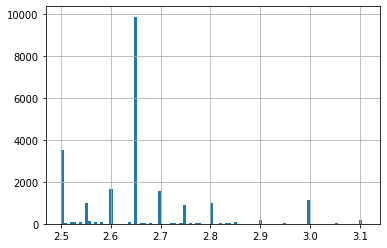

In [81]:
df['ceiling_height'].hist(bins=100)

In [82]:
df['ceiling_height'].describe()

count    22430.000000
mean         2.659465
std          0.126220
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.110000
Name: ceiling_height, dtype: float64

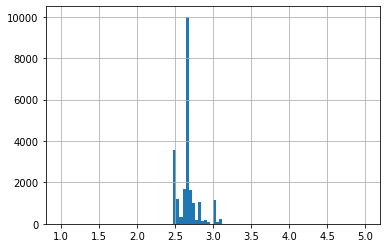

In [83]:
df['ceiling_height'].hist(bins=100, range=(1,5))

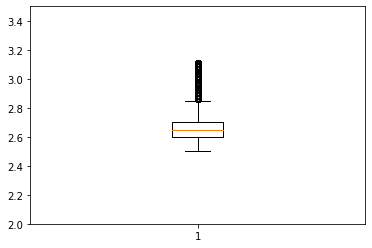

In [84]:
plt.boxplot(df['ceiling_height'])
plt.ylim(2,3.5)
plt.show()

[array([2.6, 2.5]), array([2.7 , 2.85])]

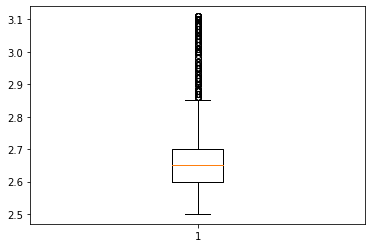

In [85]:
b = plt.boxplot(df['ceiling_height'])
[item.get_ydata() for item in b['whiskers']]

In [86]:
len(df.query('(2.45 > ceiling_height) | (ceiling_height > 3.5)'))

0

In [87]:
df_height_ok = df.query('(2.45 < ceiling_height < 3.5)')


In [88]:
df_ok = df.query('(rooms < 9) & (last_price < 20000000) & (total_area < 200)')
len(df_ok)

21906

За пограничные значения для высоты потолков возьмём от 2,45 до 2,85.

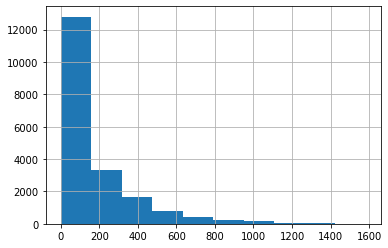

In [89]:
df_until_sale_days = df.query('sold == True')
df_until_sale_days['days_exposition'].hist()

In [90]:
on_sale_days_mean = df_until_sale_days['days_exposition'].mean()
on_sale_days_mean

176.84986183604545

In [91]:
on_sale_days_median = df_until_sale_days['days_exposition'].median()
on_sale_days_median

93.0

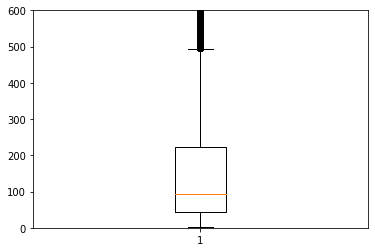

In [92]:
plt.boxplot(df_until_sale_days['days_exposition'])
plt.ylim(0,600)
plt.show()

[array([44.,  1.]), array([224., 494.])]

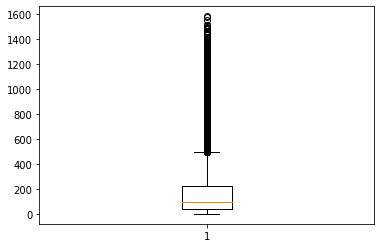

In [93]:
b = plt.boxplot(df_until_sale_days['days_exposition'])
[item.get_ydata() for item in b['whiskers']]

Использовать среднее значение для оценки срока продажи квартиры неудобно и невыгодно с точки зрения маркетинга. Есть достаточно большой хвост объектов с высоким сроком продажи, что вполне вероятно можно будет объяснить стоимостью и размерами жилья. Об этом также говорит большая разница между средним и медианным значением. 
Мы можем говорить о том, что половина пользователей закрывает сделку в срок до 93 дней.
3-й квартиль находится на отметке в 224 дня и я бы взял это за момент, когда продажа начинает затягиваться. Это может быть триггером для системы предложить пользователю доп услуги по продвижению объявления, либо намекнуть ему на снижение стоимости, чтобы сделать предложение привлекательнее.
Соответственно, если недвижимость была продана в срок до 44 дней - продажу можно считать невероятно быстрой. Такие предложения есть смысл изучить отдельно, чтобы понять, почему именно они привлекли покупателя и заставили его принять решение так быстро.


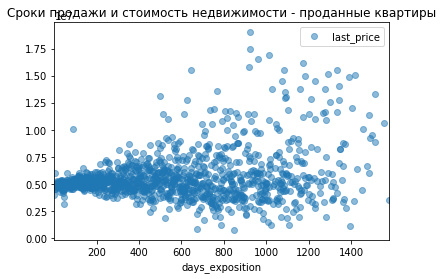

In [94]:
df_price_ok.query('sold == True').pivot_table(index='days_exposition', values='last_price').plot(style='o', title='Сроки продажи и стоимость недвижимости - проданные квартиры', alpha=0.5)

Гипотеза о том, что жилье с более высокой стоимостью продаётся дольше оправдывается лишь частично. На графике мы видим, что большинство точек расположенных высоко находятся в первой четверти графика и почти отсутствуют в 4-й. При этом мы мы также видимо увеличение количества точек и во второй четверти, что может намекать на то, что эти предложения с низкой стоимостью не так интересны для рынка

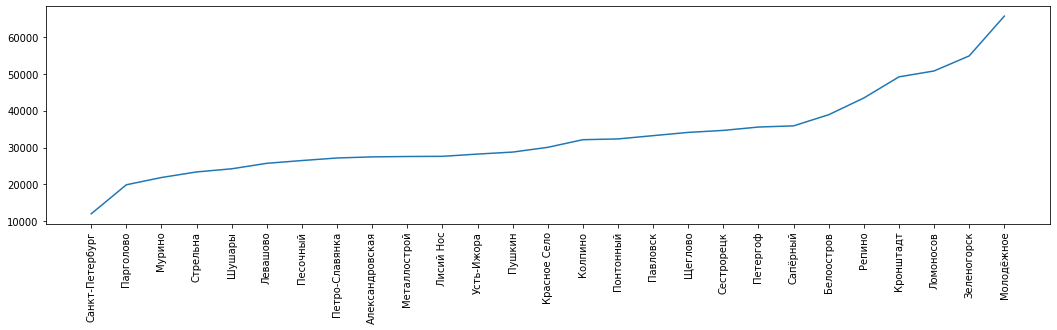

In [95]:
fig = plt.figure(figsize =(18, 4))
ax = fig.add_subplot(1,1,1)
ax.plot(df.groupby('locality_name')['cityCenters_nearest'].mean().sort_values().dropna())
plt.xticks(df.groupby('locality_name')['cityCenters_nearest'].mean().sort_values().dropna().index,rotation='vertical')
plt.show()

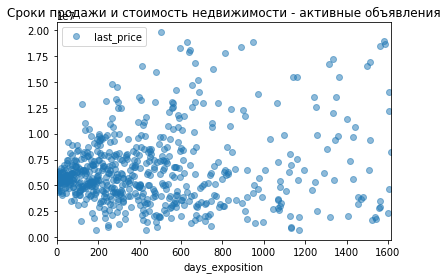

In [96]:
df_price_ok.query('sold == False').pivot_table(index='days_exposition', values='last_price').plot(style='o', title='Сроки продажи и стоимость недвижимости - активные объявления', alpha=0.5)

На графике по активным объявлениям мы можем увидеть, что есть большое количество квартир с затянувшимися сроками продажи.

Выше при оценке распределения данных по стоимости и площади жилья, кол-ву комнат и высоте потолков я сформировал 4 датафрейма очищенных от выбросов по каждому из значений. Делать общий датафрейм очищенный от выбросов по всем параметрам я пока не стал. Из особенностей можно отметить то, что отбрасывались значения преимущественно в верхнем диапазоне значений и почти нигде не отбрасывались в нижнем. Это свидительствует о большой доле жилья с невысокими габаритами и стоимостью.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d2021c10>,
      dtype=object)

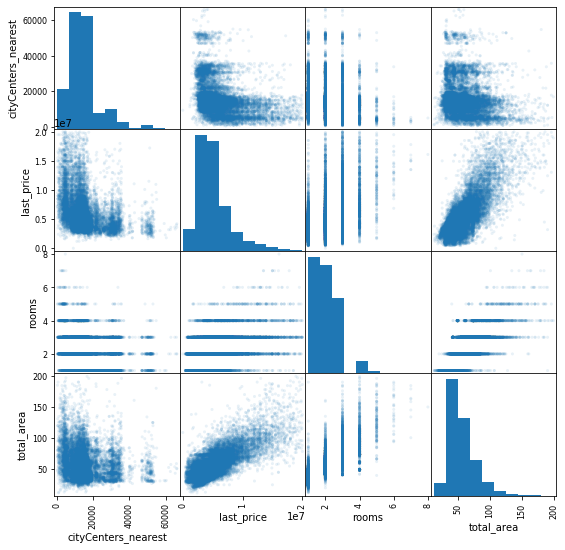

In [97]:
price_relations = df_ok.pivot_table(index=df_ok.index, values=['total_area', 'rooms', 'floor_type', 'cityCenters_nearest', 'last_price'])
pd.plotting.scatter_matrix(price_relations, figsize=(9,9), alpha=0.1)


In [98]:
price_relations.corr()

,cityCenters_nearest,last_price,rooms,total_area
cityCenters_nearest,1.000000,-0.325914,-0.101372,-0.156709
last_price,-0.325914,1.000000,0.475369,0.761511
rooms,-0.101372,0.475369,1.000000,0.790138
total_area,-0.156709,0.761511,0.790138,1.000000


Исходя из графика выше и матрицы корреляции можно сказать, что квартиры с большей площадью стоят больше, количество комнат в меньше мере влияет на стоимость в положительную сторону, а удалённость от центра эту стоимость снижает, но также не в значительной мере.

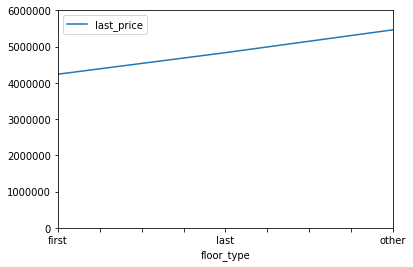

In [99]:
df_ok.pivot_table(index='floor_type', values='last_price').plot(ylim=(0,6000000))

Средняя стоимость квартиры наиболее низкая для первого этажа и наиболее высокая для промежуточных между первым и последним. Можно сделать вывод, что крайние этажи в домах не пользуются популярностью ввиду разных причин (холодный пол на первом этаже или слишком жарко летом на последних).

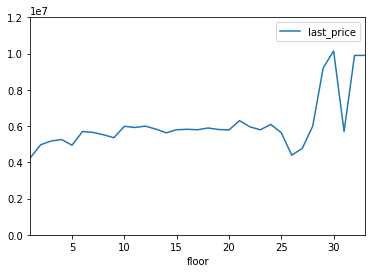

In [100]:
df_ok.pivot_table(index='floor', values='last_price').plot(ylim=(0,12000000))

Если посмотреть на распределение стоимости по этажам, то можем наблюдать небольшой рост стоимости с увеличением этажа с различными перепадами (которыми как раз могут быть последние этажи)

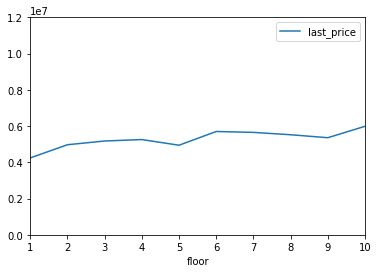

In [101]:
df_ok.pivot_table(index='floor', values='last_price').plot(ylim=(0,12000000), xlim=(1,10))

Если посмотреть на распределение в пределах 9 этаже, можно отметить самую низкую стоимость для первого этажа, небольшое колебание вниз для 5 и 9 этажей (верхние в 5-ти и 9-ти этажных домах) и рост стоимости за этажи выше.

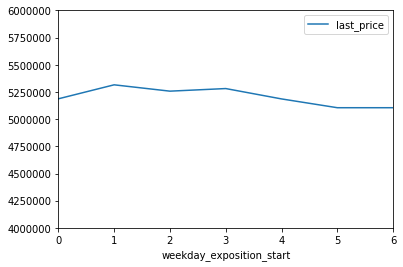

In [102]:
df_ok.pivot_table(index='weekday_exposition_start', values='last_price').plot(ylim=(4000000,6000000))

Сильной зависимости от дня недели, когда размещалось объявление не наблюдается, но по каким-то причинам получается, что выставляемые в субботу объявления оказались самыми недорогими, а вторник и среда - наоборот.

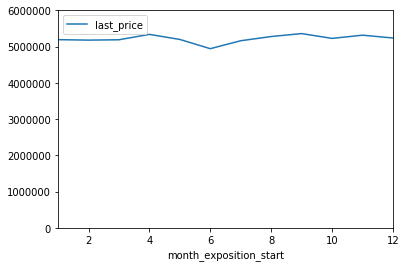

In [103]:
df_ok.pivot_table(index='month_exposition_start', values='last_price').plot(ylim=(0,6000000))

В течение года можно заметить небольшую просадку по стоимости квартир к июню и рост в апреле и сентябре. Зная средний срок продажи квартиры можно выбрать подходящий момент для размещения объявления и выиграть 100-200 тысяч рублей на продаже.

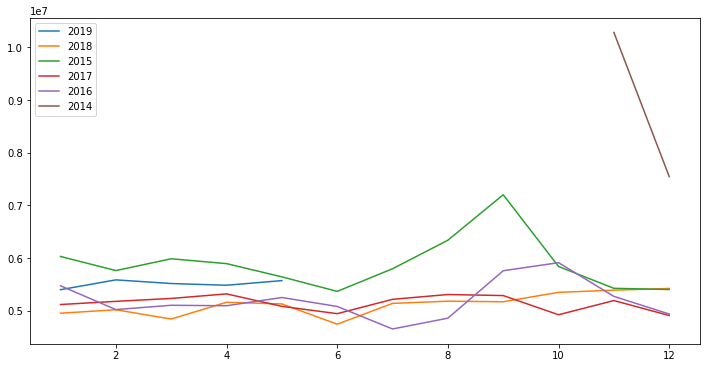

In [104]:
fig = plt.figure(figsize =(12, 6))
for year in df_ok['year_exposition_start'].unique():
    plt.plot(df_ok.loc[df['year_exposition_start'] == year].pivot_table(index='month_exposition_start', values='last_price'), label=year)
plt.legend()
plt.show()

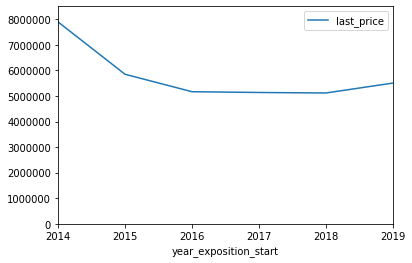

In [105]:
df_ok.pivot_table(index='year_exposition_start', values='last_price').plot(ylim=(0,8500000))

Изменение стоимости жилья с годами заметно более сильно и его можно пытаться объяснять множеством внутренних и внешний факторов рынка. Стоит отметить, что к моменту выгрузки стоимость снова начала расти. Имея данные за более длительный период можно было бы попробовать найти цикличность или связать моменты роста с какими-то событиями (финансовые кризисы, пандемия и пр)

In [106]:
#top_supply_cities = df_ok.groupby('locality_name')['last_price'].count().sort_values(ascending=False).head(10)

In [107]:
top_supply_cities = df_ok.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean'])
top_supply_cities.columns = ['count', 'price_mean']
top_supply_cities.sort_values(by='count', ascending=False).head(10)

,count,price_mean
locality_name,,
Санкт-Петербург,14131,108185.171191
Мурино,590,86087.512017
Кудрово,471,95326.179108
Шушары,439,78655.103189
Всеволожск,393,67153.884987
Пушкин,342,101756.332544
Колпино,328,75440.952226
Парголово,325,90362.344800
Гатчина,304,68665.848553


In [108]:
top_supply_cities.sort_values(by='price_mean', ascending=False)

,count,price_mean
locality_name,,
Санкт-Петербург,14131,108185.171191
Зеленогорск,23,106043.631739
Пушкин,342,101756.332544
Сестрорецк,178,101210.268427
Лисий Нос,3,100660.816667
...,...,...
Совхозный,2,12629.130000
Выскатка,2,12335.480000
Вахнова Кара,1,11688.310000


В таблице выше мы видим наиболее дорогие и дешевые по средней стоимости за квадратный метр нас пункты. Ожидаемо в верху этого списка мы видим Спб, но также видим достаточно большое кол-во нас пунктов в которых 1-2 объявления, из-за чего самая высокая средняя стоимость в поселке Лисий Нос. Для большей наглядности ограничим нас пункты кол-во объявлений.

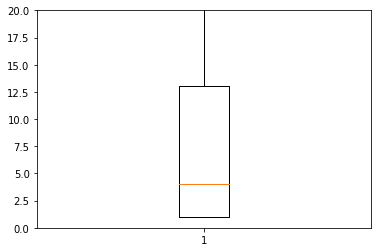

In [109]:
plt.boxplot(top_supply_cities['count'])
plt.ylim(0,20)
plt.show()

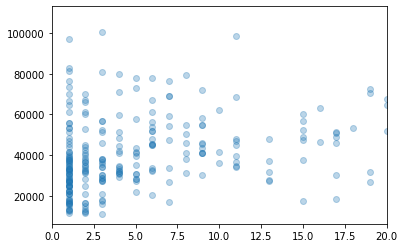

In [110]:
plt.scatter(top_supply_cities['count'], top_supply_cities['price_mean'], alpha=0.3)
plt.xlim(0,20)
plt.show()

In [111]:
top_supply_cities['count'].median()

4.0

In [112]:
top_supply_cities.query('count >= 3').sort_values(by='price_mean', ascending=False)

,count,price_mean
locality_name,,
Санкт-Петербург,14131,108185.171191
Зеленогорск,23,106043.631739
Пушкин,342,101756.332544
Сестрорецк,178,101210.268427
Лисий Нос,3,100660.816667
...,...,...
Оредеж,3,17707.713333
Бокситогорск,15,17457.329333
Никольский,7,17212.380000


Т.к. более чем в половине нас пунктов объявлений до 4 включительно, я оставил лишь те, в которых объявлений больше 3-х, чтобы средняя цена хотя бы немного была средней.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


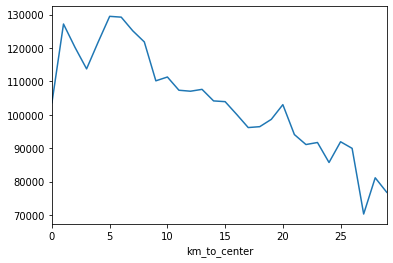

In [113]:
df_spb = df_ok.loc[df['locality_name'] == 'Санкт-Петербург']
df_spb['km_to_center'] = (df_spb['cityCenters_nearest']/1000).round()
df_spb.groupby('km_to_center')['price_per_meter'].mean().plot()

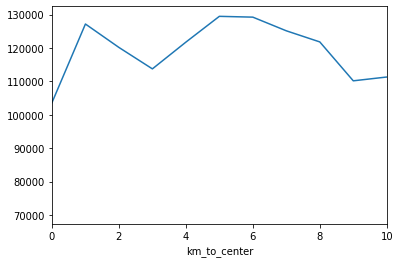

In [114]:
df_spb.groupby('km_to_center')['price_per_meter'].mean().plot(xlim=(0,10))

Оценив среднюю стоимость квадратного метра при удалении от центра можно увидеть, что резкое её снижение начинается с 6 км от центра и далее с перепадами стоимость продолжает падать. Но т.к. при 7 км от центра стоимость ещё остаётся высокой, я возьму радиус в 8 км границей центра.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d197b490>,
      dtype=object)

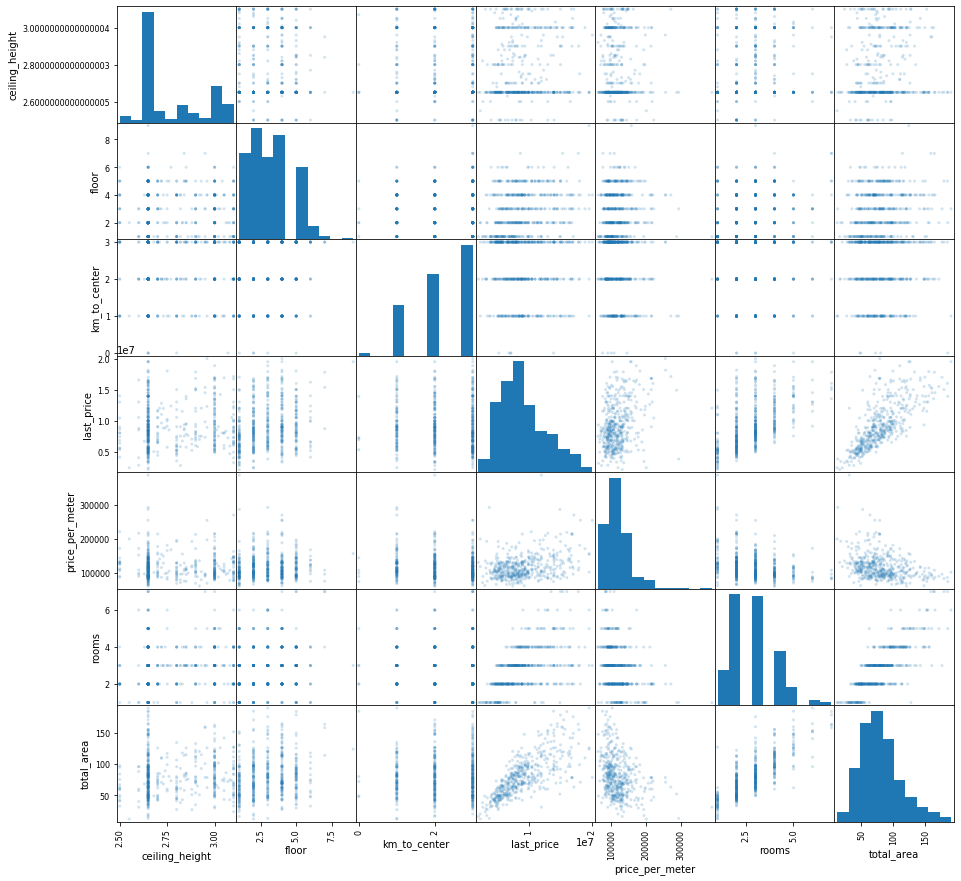

In [115]:
df_spb_center = df_spb.query('km_to_center <= 3')
spb_center_data = df_spb_center.pivot_table(index=df_spb_center.index, values=['last_price', 'total_area', 'rooms', 'ceiling_height', 'price_per_meter', 'km_to_center', 'floor'])
pd.plotting.scatter_matrix(spb_center_data, figsize=(15,15), alpha=0.2)


In [116]:
spb_center_data.corr()['last_price']

ceiling_height     0.074500
floor              0.250461
km_to_center      -0.039524
last_price         1.000000
price_per_meter    0.328866
rooms              0.551367
total_area         0.740546
Name: last_price, dtype: float64

Исходя из проанализированных данных больше всего со стоимостью жилья связаны количество комнат и площадь (которые также взаимосвязаны между собой.

In [117]:
spb_center_data.corr()['price_per_meter']

ceiling_height    -0.036806
floor              0.055535
km_to_center      -0.123989
last_price         0.328866
price_per_meter    1.000000
rooms             -0.298879
total_area        -0.324364
Name: price_per_meter, dtype: float64

Но если посмотреть на стоимость квадратного метра, то здесь куда более заметно влияние количества комнат и площади. Получается, что квартиры с большим количеством комнат и больше площадью стоят больше, но каждый квадратный метр в них стоит меньше. Так же на стоимость кв метра совсем незначительно влияет этаж расположения квартиры.

In [118]:
spb_outskirts_data = df_spb.query('km_to_center >=8').pivot_table(index=df_spb.query('km_to_center >=8').index, values=['last_price', 'total_area', 'rooms', 'ceiling_height', 'price_per_meter', 'km_to_center', 'floor'])
spb_outskirts_data.corr()['price_per_meter']

ceiling_height     0.282043
floor              0.223699
km_to_center      -0.242301
last_price         0.494285
price_per_meter    1.000000
rooms             -0.265849
total_area        -0.016148
Name: price_per_meter, dtype: float64

In [119]:
pd.concat([spb_center_data.corr()['price_per_meter'],spb_outskirts_data.corr()['price_per_meter']], axis=1)

,price_per_meter,price_per_meter
ceiling_height,-0.036806,0.282043
floor,0.055535,0.223699
km_to_center,-0.123989,-0.242301
last_price,0.328866,0.494285
price_per_meter,1.000000,1.000000
rooms,-0.298879,-0.265849
total_area,-0.324364,-0.016148


Разница между факторами влиящими на стоимость квадрата в центре и за его пределами видна на таблице выше. Рост общей площади за пределами центра уже не так сильно снижает стоимость квадрата, а высота потолков становится куда важнее. Также стоит отметить, что в пределах центра стоимость квадрата имеет совсем незначительную тендецию к снижению с приближением к центру (более наглядно зависимость в этом регионе можно увидеть на одном из графиков выше), а за пределами центра эта тендеция получает обратный характер.

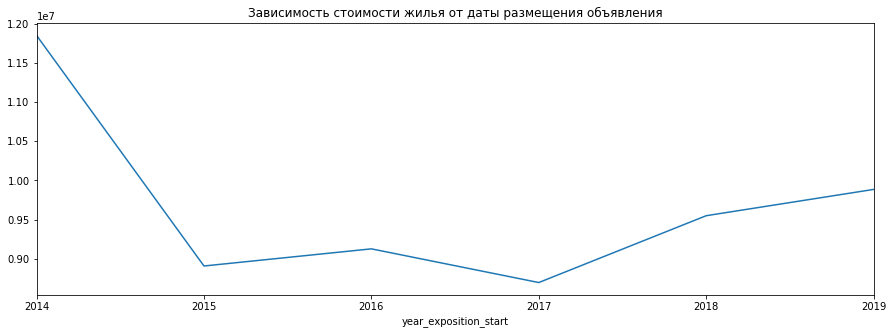

In [123]:
df_spb_center.groupby('year_exposition_start')['last_price'].mean().plot(figsize=(15,5))
plt.title('Зависимость стоимости жилья от даты размещения объявления')
plt.show()

Исходя из графика выше нельзя сказать, что со вренем стоимость предлагаемого жилья изменяется, но можно утверждать, что расчёт количество предложений.

### Вывод

Результаты исследовательского анализа данных:
 - мы избавились от выбросов и аномальных значений, чтобы анализировать типовые объявления о продаже недвижимости
 - изучили срок продажи квартир и выделили временные зоны от "быстрой продажи" к "никто не покупает"
 - определили нас пункты с наиболее высокими и низкими стоимостями за квадратный метр жилья
 - проанализировали факторы влияющие на стоимост квадрата в центре Спб и за пределами центра

## Общий вывод

1. Предобработка данных. В результате изучения данных было обнаруженно большое количество пропусков и некорректно заполненных данных. Для избежания проблем со сбором данных (и принятыми на их основании решений), рекомендуется:
 - сделать ряд полей для заполнения обязательным, а так же добавить туда проверки (к примеру, чтобы высоту помещения нельзя было указать выше 6 метров)
 - фиксировать id для объявлений и их авторов - это поможет избежать дублей и мошеничества
 - сделать базу адресов с id для каждого дома и агрегированной информацией (кол-во этаже, высота помещений). Можно пойти дальше и собирать информацию по типовым планировкам. Это позволит сократить время на заполнение форм продавцом и дать более полную информацию для покупателя. В будущем возможно станет актуальным использование фильтров по планировке либо другим особенностям квартир
 - также необходимо обратить внимание на сбор информации от расстоянии с помощью внутренних сервисов, по части записей эти данные полностью либо частично отсутствуют
2. Исследовательских анализ. 
Основные факторы влияющие на стоимость жилья это его площадь и город, в котором оно находится. В среднем можно сказать, что продажа квартиры будет занимать около 95 дней, но это будет влиять как стоимость объекта недвижимости, так и его востребованность рынком. В рамках исследования мы выделили сроки, на которые можно ориентироваться для принятия дополнительных мер (объявление может висеть до 224 дней, после необходимо обязательно с ним что-то сделать). 
Большая часть всех объявлений (65%) и самая большая стоимость кв метра в Санкт-Петербурге (в среднем 103 226 рублей за квадратный метр), в наиболее крупном нас пункте исследуемого региона, поэтому ему было уделено отдельное внимание.
В центре Спб жильё наиболее дорогое (в среднем 110 514 рублей за квадратный метр), но объекты с высокой площадью имеют меньшую стоимость за квадратный метр по сравнению с предложениями за пределами центра. медианная площадь недвижимости в центре Спб 75 кв метров, а по всему городу - всего 52 (за пределами Спб это значение 46,5 м). Также есть ряд факторов влияющих на стоимость жилья не так значительно (но по разному в центре и за его пределами) на стоимость - это высота потолков, этаж здания и пр.
 

In [158]:
df_ok.query('locality_name != "Санкт-Петербург"')['total_area'].median()

46.5

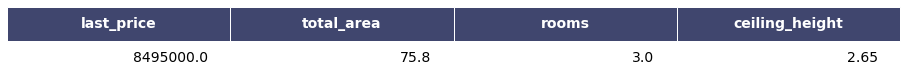

In [135]:
import numpy as np
import six

def render_mpl_table(data, col_width=6.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

ax = render_mpl_table(pd.DataFrame(df_spb_center.describe().loc['50%'][['last_price', 'total_area', 'rooms', 'ceiling_height']]).T, header_columns=0, col_width=4.0)